In [8]:
import os
import gc
import re
import json
import pickle
import datetime
from tqdm import tqdm

import numpy as np
import pandas as pd
pd.options.display.max_columns = None

from typing import Union

import seaborn
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

from scipy.stats import linregress

from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

import lightgbm as lgb

In [3]:
VERSION = 'v00000'

In [6]:
train = pd.read_pickle('/Users/rui/Documents/repositories/m5_forecasting_accuracy/v01000/features/melted_train.pkl')

In [9]:
print(train.shape)
train.tail()

(46881677, 46)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,month,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,quarter,week,day,dayofweek,is_year_end,is_year_start,is_quarter_end,is_quarter_start,is_month_end,is_month_start,is_weekend,event_name_1_lag_t1,event_name_1_lag_t2,event_type_1_lag_t1,event_type_1_lag_t2,event_name_2_lag_t1,event_name_2_lag_t2,event_type_2_lag_t1,event_type_2_lag_t2,sell_price,price_MAX,price_MIN,price_STD,price_MEAN,price_NORM,price_NUNIQUE,item_NUNIQUE,price_momentum
46881672,FOODS_3_823_WI_3_validation,1432,2,0,9,2,d_1941,0,2016-05-22,11617,5,19,2,3,1,0,0,0,2,20,22,6,0,0,0,0,0,0,1,19.0,19.0,2.0,2.0,3.0,3.0,1.0,1.0,2.980469,2.980469,2.480469,0.171875,2.802734,1.000000,5.0,206.0,1.0
46881673,FOODS_3_824_WI_3_validation,1433,2,0,9,2,d_1941,0,2016-05-22,11617,5,19,2,3,1,0,0,0,2,20,22,6,0,0,0,0,0,0,1,19.0,19.0,2.0,2.0,3.0,3.0,1.0,1.0,2.480469,2.679688,2.000000,0.252930,2.507812,0.925781,4.0,135.0,1.0
46881674,FOODS_3_825_WI_3_validation,1434,2,0,9,2,d_1941,0,2016-05-22,11617,5,19,2,3,1,0,0,0,2,20,22,6,0,0,0,0,0,0,1,19.0,19.0,2.0,2.0,3.0,3.0,1.0,1.0,3.980469,4.378906,3.980469,0.187866,4.117188,0.909180,3.0,150.0,1.0
46881675,FOODS_3_826_WI_3_validation,1435,2,0,9,2,d_1941,0,2016-05-22,11617,5,19,2,3,1,0,0,0,2,20,22,6,0,0,0,0,0,0,1,19.0,19.0,2.0,2.0,3.0,3.0,1.0,1.0,1.280273,1.280273,1.280273,0.000000,1.280273,1.000000,1.0,44.0,1.0
46881676,FOODS_3_827_WI_3_validation,1436,2,0,9,2,d_1941,0,2016-05-22,11617,5,19,2,3,1,0,0,0,2,20,22,6,0,0,0,0,0,0,1,19.0,19.0,2.0,2.0,3.0,3.0,1.0,1.0,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.0,142.0,1.0


In [11]:
use_cols = ['id', 'd', 'sales', 'date', 'sell_price']
temp = train[use_cols]

In [12]:
print(temp.shape)
temp.head()

(46881677, 5)


,id,d,sales,date,sell_price
0,HOBBIES_1_008_CA_1_validation,d_1,12,2011-01-29,0.459961
1,HOBBIES_1_009_CA_1_validation,d_1,2,2011-01-29,1.559570
2,HOBBIES_1_010_CA_1_validation,d_1,0,2011-01-29,3.169922
3,HOBBIES_1_012_CA_1_validation,d_1,0,2011-01-29,5.980469
4,HOBBIES_1_015_CA_1_validation,d_1,4,2011-01-29,0.700195


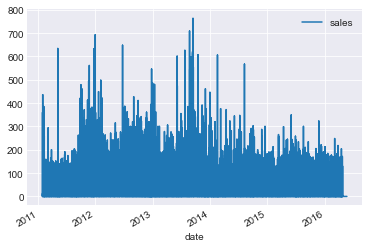

In [19]:
temp.plot(x='date', y='sales')

----

In [1]:
class LGBM_Model():
    def __init__(self, X, y, cv_param, model_param, train_param, groups=None, custom_metric=None):
        self.cv = self.set_cv(cv_param)
        self.custom_metric = custom_metric
        self.models = self.fit(X, y, model_param, train_param, groups)

    def set_cv(self, cv_param):
        cv = TimeSeriesSplit(n_splits=cv_param['n_splits'], max_train_size=cv_param['max_train_size'])
        return cv

    def fit(self, X, y, model_param, train_param, groups):
        models = []
        for n_fold, (train_idx, valid_idx) in enumerate(self.cv.split(X)):
            print(f"\n{n_fold + 1} of {self.cv.get_n_splits()} Fold:\n")
            train_X, train_y = X.iloc[train_idx], y.iloc[train_idx]
            valid_X, valid_y = X.iloc[valid_idx], y.iloc[valid_idx]

            print('Train DataFrame Size:', train_X.shape)
            print('Valid DataFrame Size:', valid_X.shape)
            train_dataset = lgb.Dataset(train_X, label=train_y)
            valid_dataset = lgb.Dataset(valid_X, label=valid_y, reference=train_dataset)
            model = lgb.train(
                model_param,
                train_dataset,
                valid_sets=[train_dataset, valid_dataset],
                valid_names=["train", "valid"],
                **train_param
            )
            models.append(model)
            del train_X, valid_X, train_y, valid_y; gc.collect()
        return models

    def get_models(self):
        return self.models

    def predict(self, data):
        models = self.get_models()
        return [m.predict(data.values, num_iteration=m.best_iteration) for m in models]

    def save_importance(self, filepath, max_num_features=50, figsize=(15, 20), plot=False):
        models = self.get_models()
        # Define Feature Importance DataFrame.
        imp_df = pd.DataFrame(
            [m.feature_importance() for m in models],
            columns=models[0].feature_name()
        ).T
        imp_df['AVG_Importance'] = imp_df.iloc[:, :len(models)].mean(axis=1)
        imp_df['STD_Importance'] = imp_df.iloc[:, :len(models)].std(axis=1)
        imp_df.sort_values(by='AVG_Importance', inplace=True)
        # Plot Importance DataFrame.
        plt.figure(figsize=figsize)
        imp_df[-max_num_features:].plot(
            kind='barh', title='Feature importance', figsize=figsize,
            y='AVG_Importance', xerr='STD_Importance', align="center"
        )
        if plot:
            plt.show()
        plt.savefig(filepath)
        plt.close('all')

In [ ]:
def estimate_rmsle(actual, preds):
    return mean_squared_error(np.log1p(actual), np.log1p(preds), squared=False)


def lgbm_rmsle(preds, data):
    return 'RMSLE', estimate_rmsle(preds, data.get_label()), False


def train_model(df, features, target):
    cv_param = {
        "n_splits": 3,
        "max_train_size": None
    }

    model_param = {
        "boosting_type": "gbdt",
        "metric": "None",
        "objective": "poisson",
        "seed": 11,
        "learning_rate": 0.3,
        'max_depth': 5,
        'num_leaves': 32,
        'min_data_in_leaf': 50,
        "bagging_fraction": 0.8,
        "bagging_freq": 10,
        "feature_fraction": 0.8,
        "verbosity": -1
    }

    train_param = {
        "num_boost_round": 100000,
        "early_stopping_rounds": 50,
        "verbose_eval": 100,
        "feval": lgbm_rmsle
    }

    print(cv_param)
    print(model_param)
    print(train_param)

    lgbm_model = LGBM_Model(df[features], df[target], cv_param, model_param, train_param)
    lgbm_model.save_importance(filepath=f'result/importance/{VERSION}.png')
    dump_pickle(lgbm_model.get_models(), f'result/model/{VERSION}.pkl')

In [ ]:
def split_train_eval_submit(df, pred_interval=28):
    latest_date = df['date'].max()
    submit_date = latest_date - datetime.timedelta(days=pred_interval)
    submit_mask = (df["date"] > submit_date)

    eval_date = latest_date - datetime.timedelta(days=pred_interval * 2)
    eval_mask = ((df["date"] > eval_date) & (df["date"] <= submit_date))

    train_mask = ((~eval_mask) & (~submit_mask))
    return df[train_mask], df[eval_mask], df[submit_mask]

In [ ]:
target = 'sales'
cols_to_drop = ['id', 'wm_yr_wk', 'd', 'date'] + [target]
features = train.columns.tolist()
features = [f for f in features if f not in cols_to_drop]

train_data, eval_data, submit_data = split_train_eval_submit(train)
train_model(train_data, features, target)